In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import os
import sys

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units
0,202119-6909,2021-05-15,202119,6909,93,Arale,21274,13.3,Premium,2.0,35.0
1,202120-6909,2021-05-22,202120,6909,93,Arale,21274,13.3,Premium,0.0,70.0
2,202121-6909,2021-05-29,202121,6909,93,Arale,21274,13.3,Premium,3.0,137.0
3,202122-6909,2021-06-05,202122,6909,93,Arale,21274,13.3,Premium,0.0,274.0
4,202123-6909,2021-06-12,202123,6909,93,Arale,21274,13.3,Premium,0.0,333.0
...,...,...,...,...,...,...,...,...,...,...,...
15449,202317-247737,2023-04-29,202317,247737,15,Arale,10637,13.3,Premium,0.0,62.0
15450,202317-247737,2023-04-29,202317,247737,24,Arale,10637,13.3,Premium,0.0,3.0
15451,202318-247737,2023-05-06,202318,247737,3,Arale,10637,13.3,Premium,22.0,0.0
15452,202318-247737,2023-05-06,202318,247737,15,Arale,10637,13.3,Premium,68.0,78.0


In [4]:
train.columns

Index(['id', 'date', 'year_week', 'product_number', 'reporterhq_id',
       'prod_category', 'specs', 'display_size', 'segment', 'sales_units',
       'inventory_units'],
      dtype='object')

In [5]:
# Convert "date" column to datetime

train['date'] = pd.to_datetime(train['date'])

In [6]:
# Group by "id" and calculate total sales of column "sales_units"

sales = train.groupby('product_number').agg({'sales_units': 'sum'})

# Set index to "id" column

sales = sales.reset_index().sort_values(by='sales_units', ascending=False).set_index('product_number')

sales

,sales_units
product_number,
45402,10975.0
24675,10002.0
247737,8023.0
41454,7984.0
33558,7651.0
...,...
237867,1957.0
6909,1810.0
32571,1771.0


In [7]:
no_sales = sales[sales['sales_units'] == 0]

no_sales

,sales_units
product_number,


<Axes: xlabel='date'>

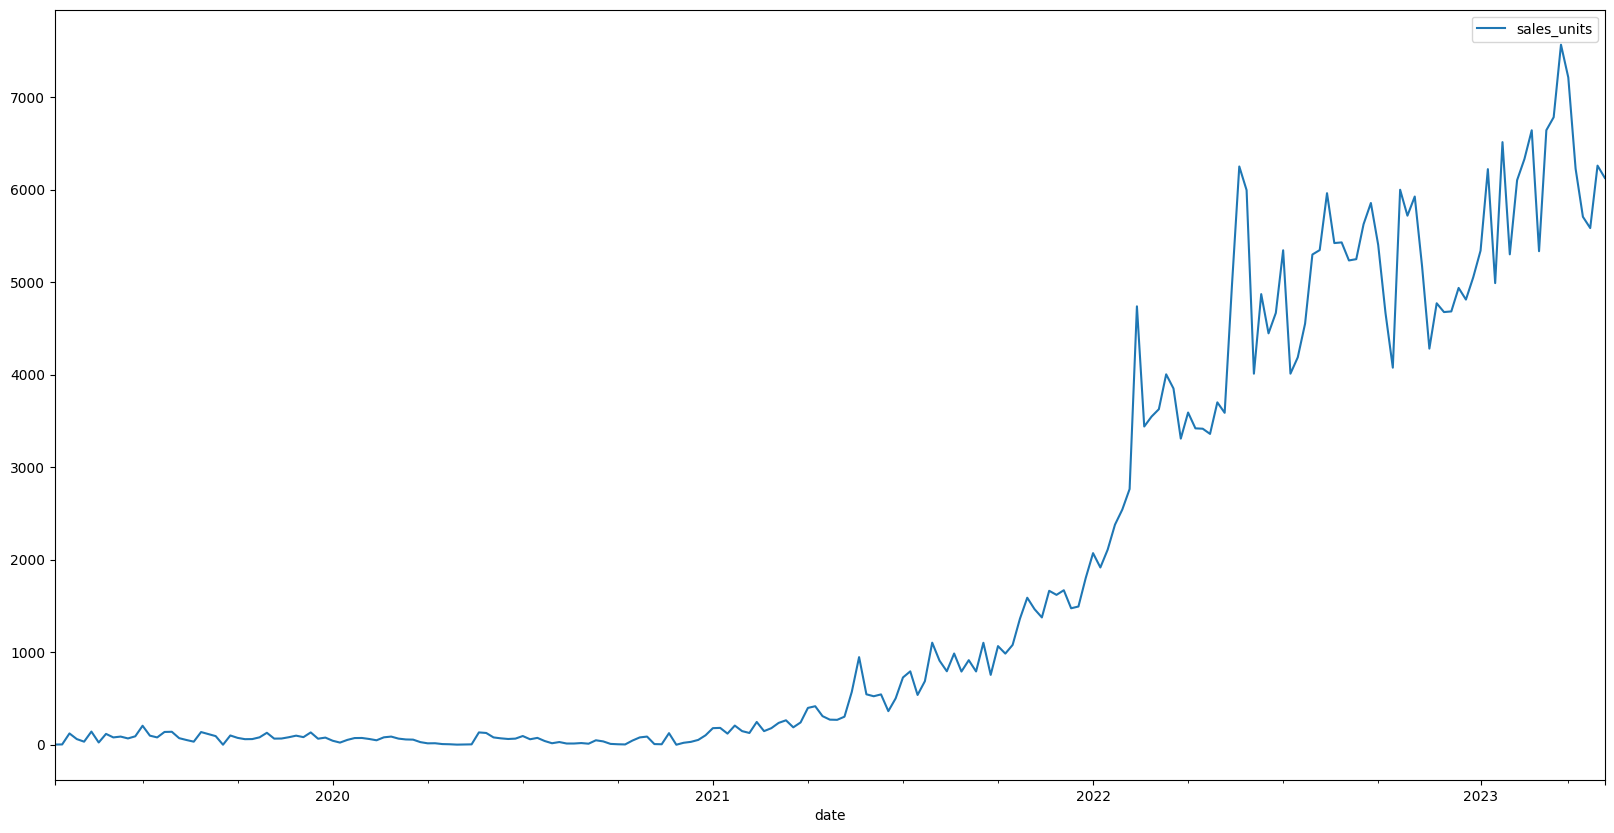

In [8]:
# Plot sales over time

sales = train.groupby('date').agg({'sales_units': 'sum'})

sales.plot(figsize=(20, 10))

<Axes: xlabel='date'>

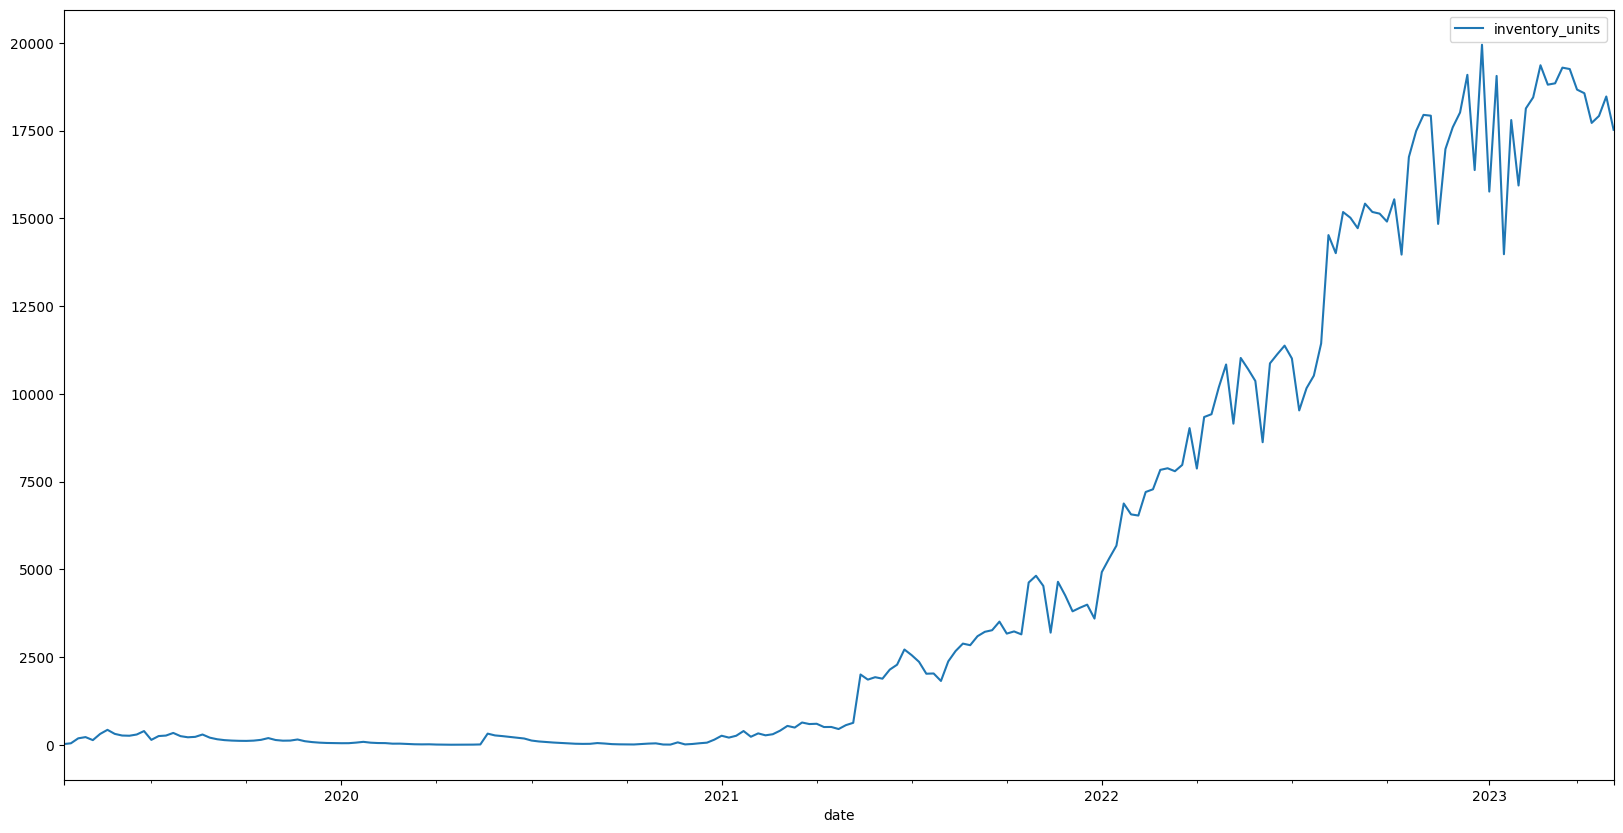

In [9]:
# Plot sales over time

sales = train.groupby('date').agg({'inventory_units': 'sum'})

sales.plot(figsize=(20, 10))

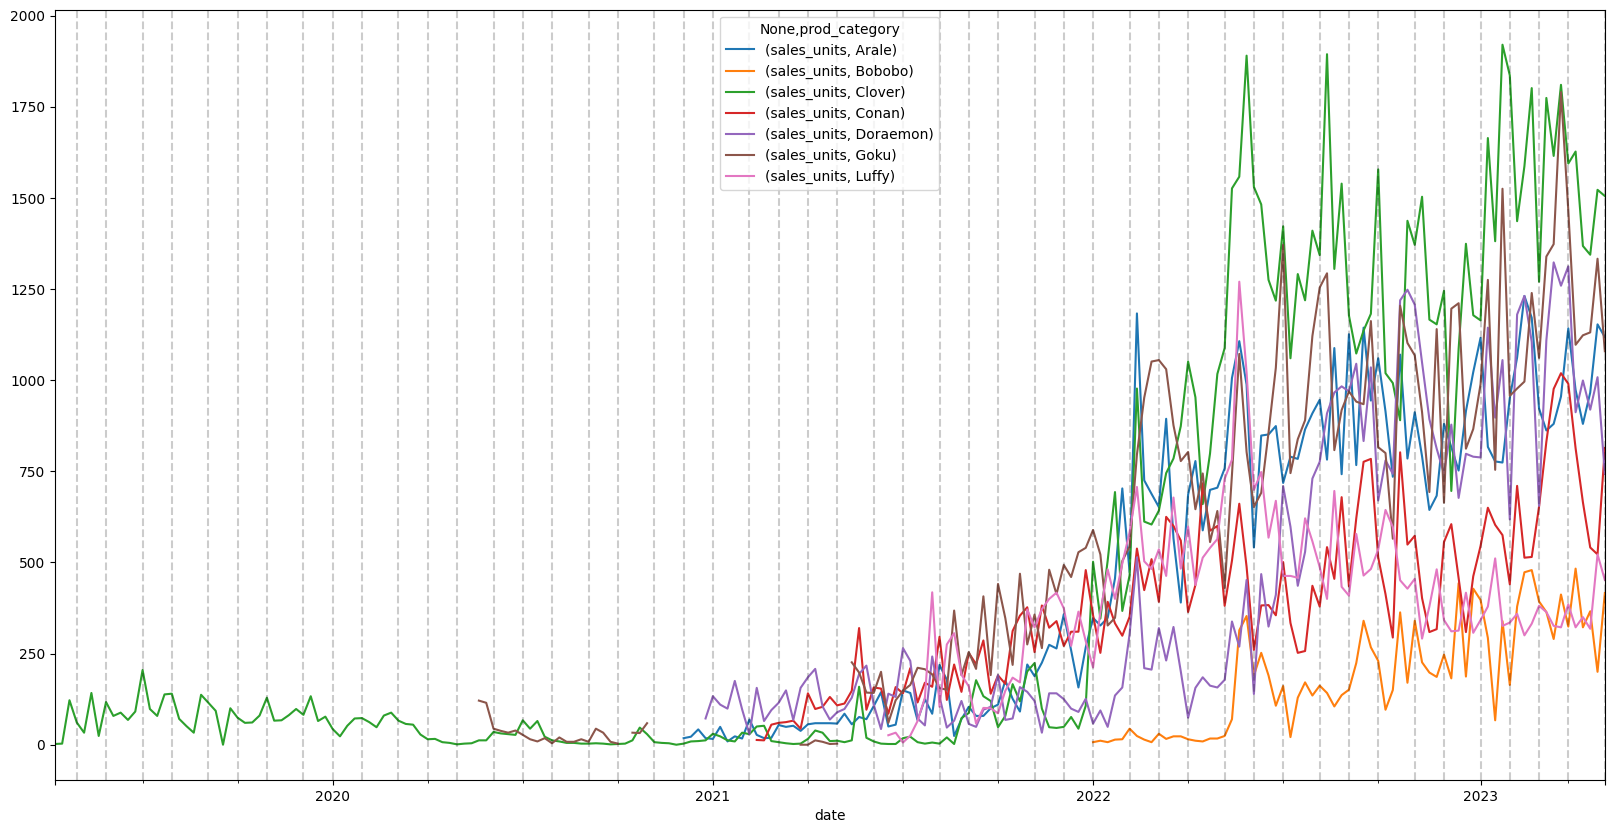

In [10]:
# Plot sales over time decomposed by prod_category

def plot_sales_by_prod(df, group_time=False, correct_days=False, column='sales_units'):
    # Group by "date" and "prod_category" and calculate total sales of column "sales_units" 

    df = df.copy()

    if group_time == 'month':
        
        # Map "date" column to year-month format

        df['date'] = df['date'].map(lambda x: x.strftime('%Y-%m'))

        # Convert "date" column to datetime

        df['date'] = pd.to_datetime(df['date'])
    sales = df.groupby(['date', 'prod_category']).agg({column: 'sum'})

    if group_time == 'month' and correct_days:
        # Correct the number of days in each month
        days_in_month = sales.index.get_level_values('date').daysinmonth
        sales[column] = sales[column] / days_in_month


    # Plot sales over time decomposed by prod_category

    sales.unstack().plot(figsize=(20, 10))

    # Plot vertical lines for each month

    for i in range(1, 13):
        for j in range(2018, 2024):
            plt.axvline(pd.to_datetime(f'{j}-{i}-01'), color='k', linestyle='--', alpha=0.2)


plot_sales_by_prod(train)
    

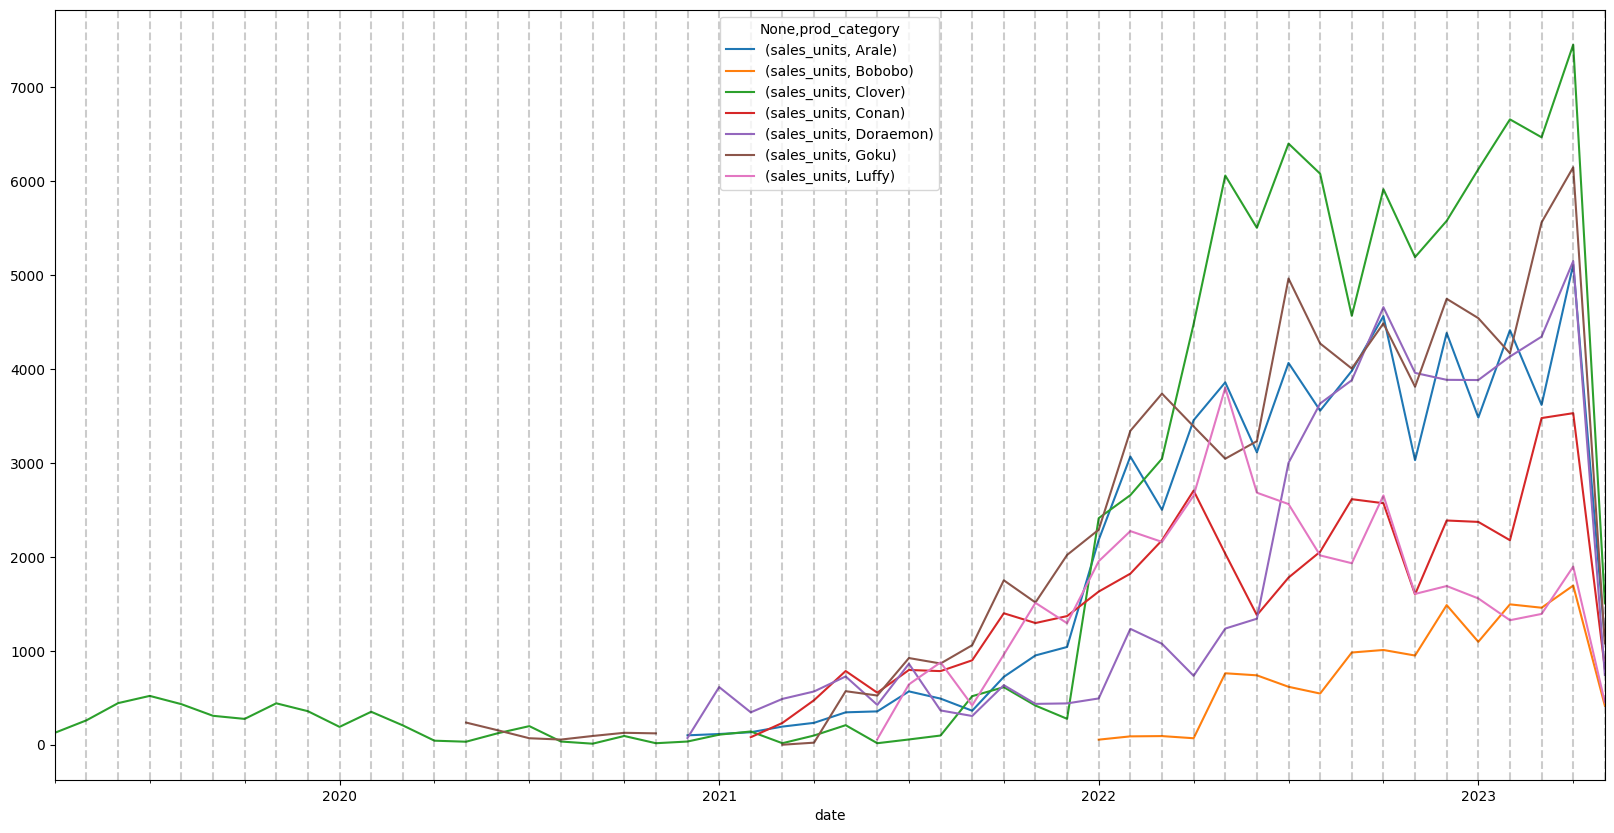

In [11]:
plot_sales_by_prod(train, group_time='month')

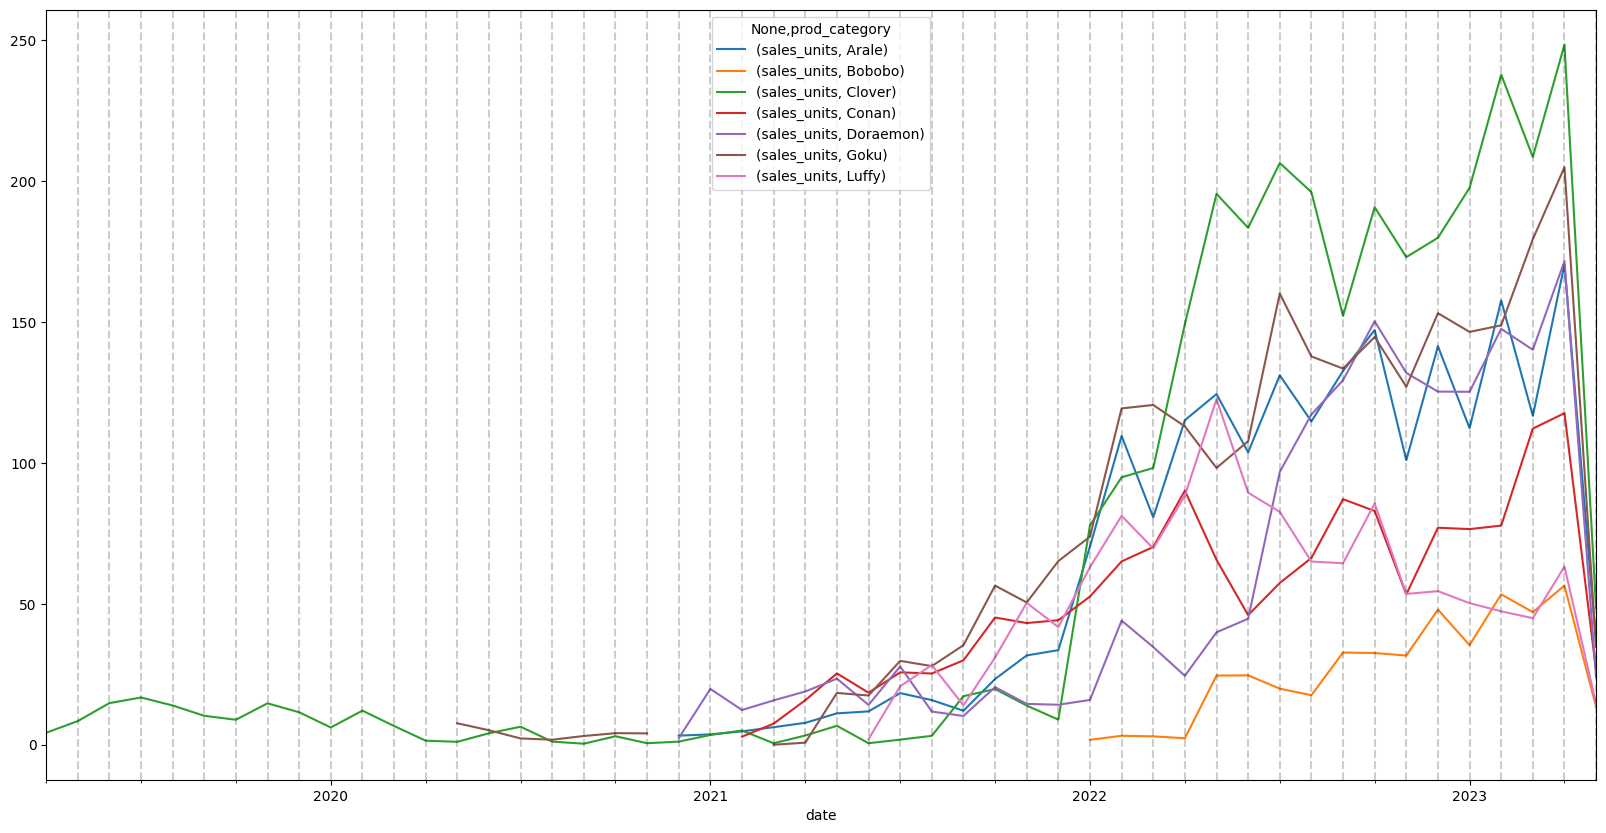

In [12]:
plot_sales_by_prod(train, group_time='month', correct_days=True)

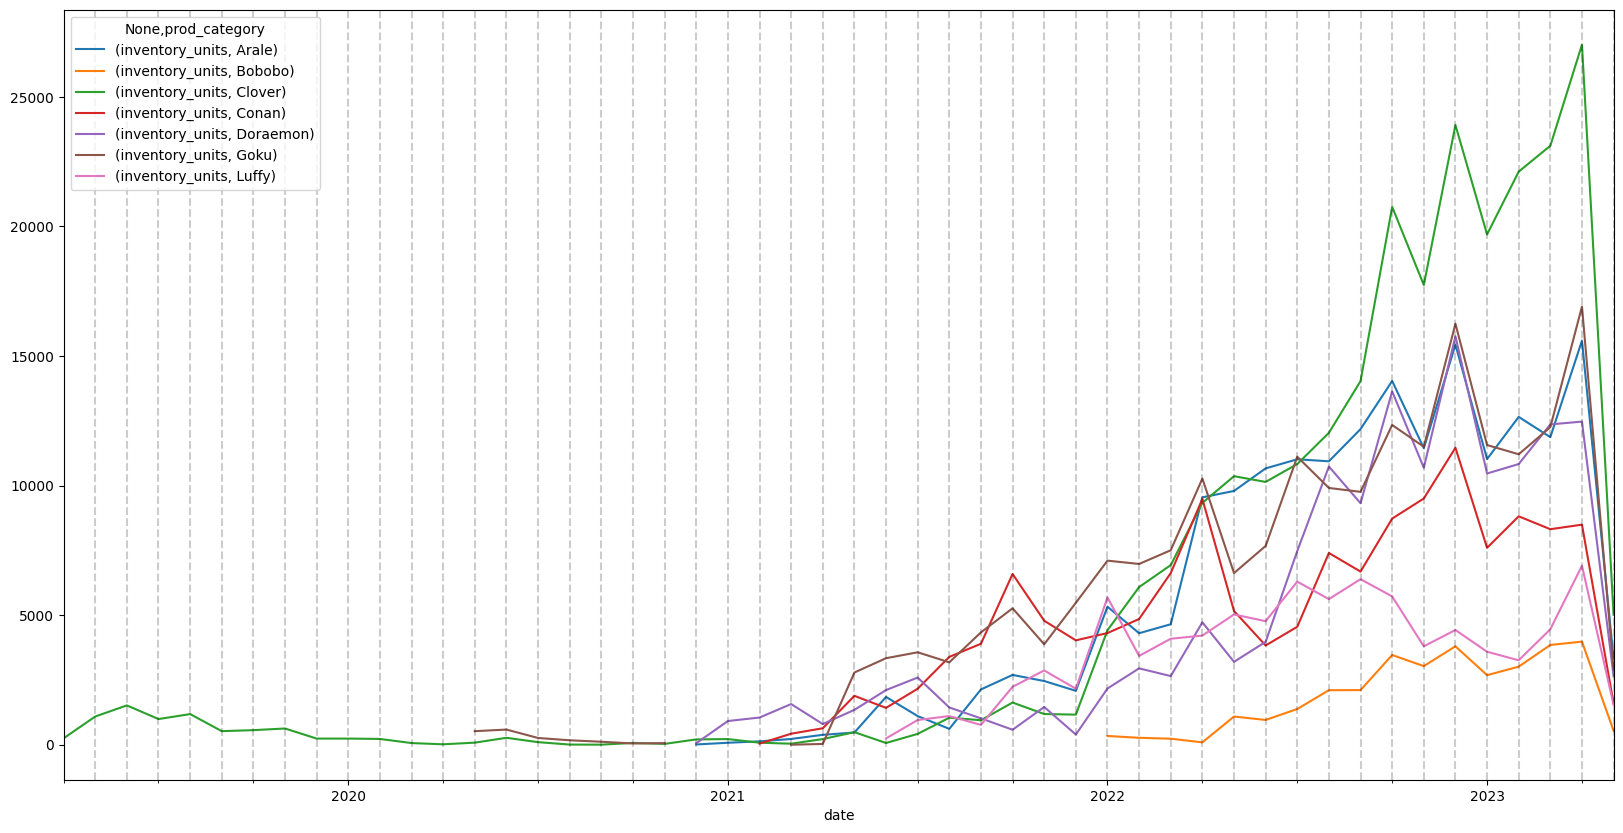

In [13]:
plot_sales_by_prod(train, group_time='month', correct_days=False, column='inventory_units')

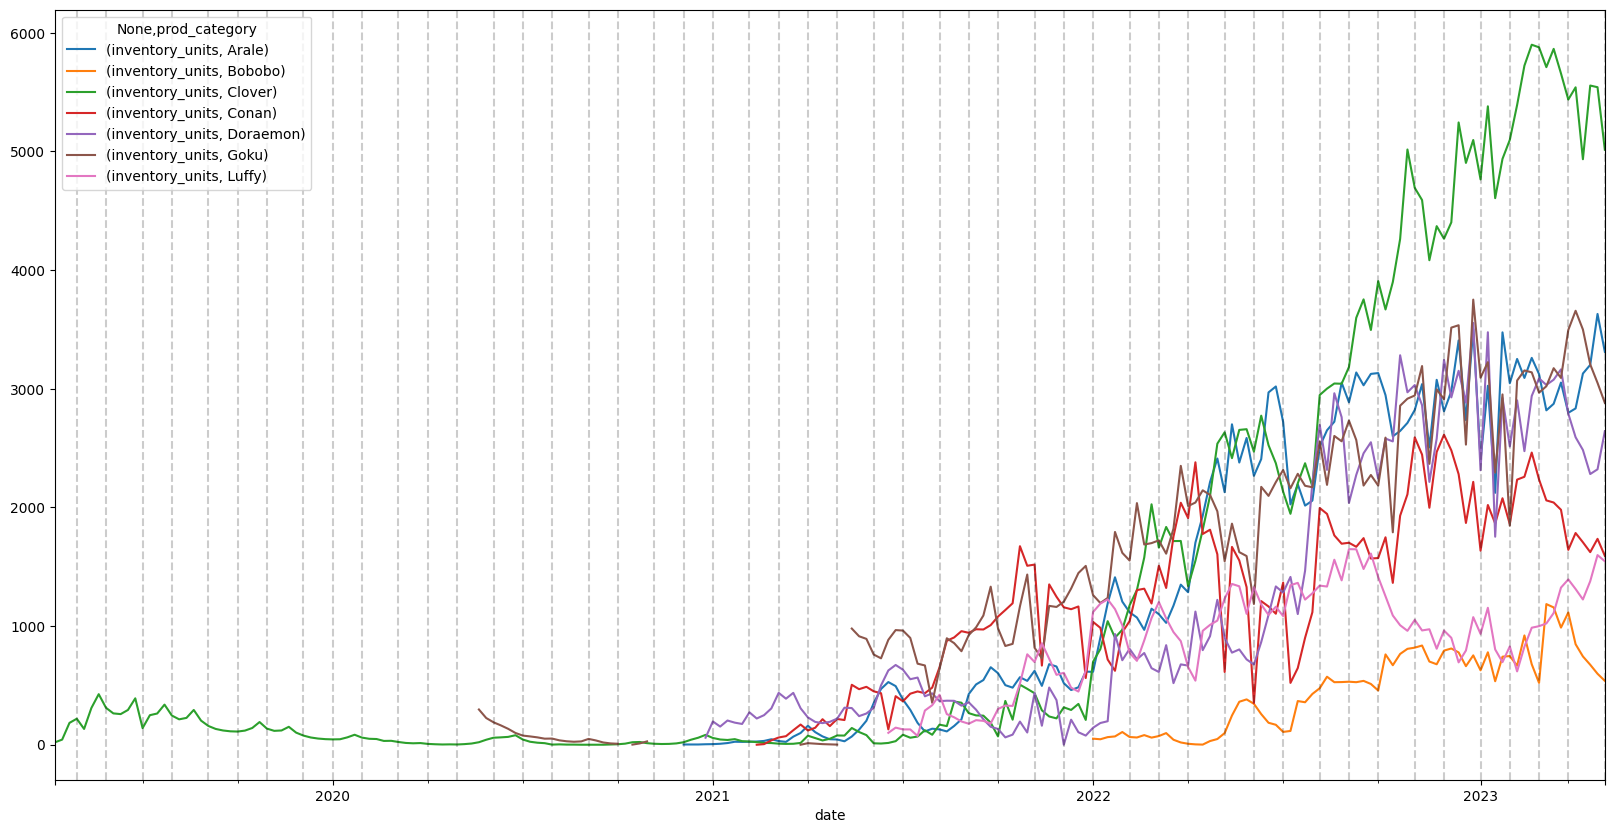

In [14]:
plot_sales_by_prod(train, column='inventory_units')

In [15]:
# We want to plot and save to a file the sales of each product over time

def plot_sales_by_prod(df, product_id):
    df = df.copy()
    df = df[df['product_number'] == product_id]
    df = df.groupby('date').agg({'inventory_units': 'sum'})
    df.plot(figsize=(20, 10))
    plt.savefig(f'past_inventory/{product_id}.png')
    plt.close()

def plot_all_sales_by_prod(df):
    for product_id in df['product_number'].unique():
        plot_sales_by_prod(df, product_id)


# plot_all_sales_by_prod(train)

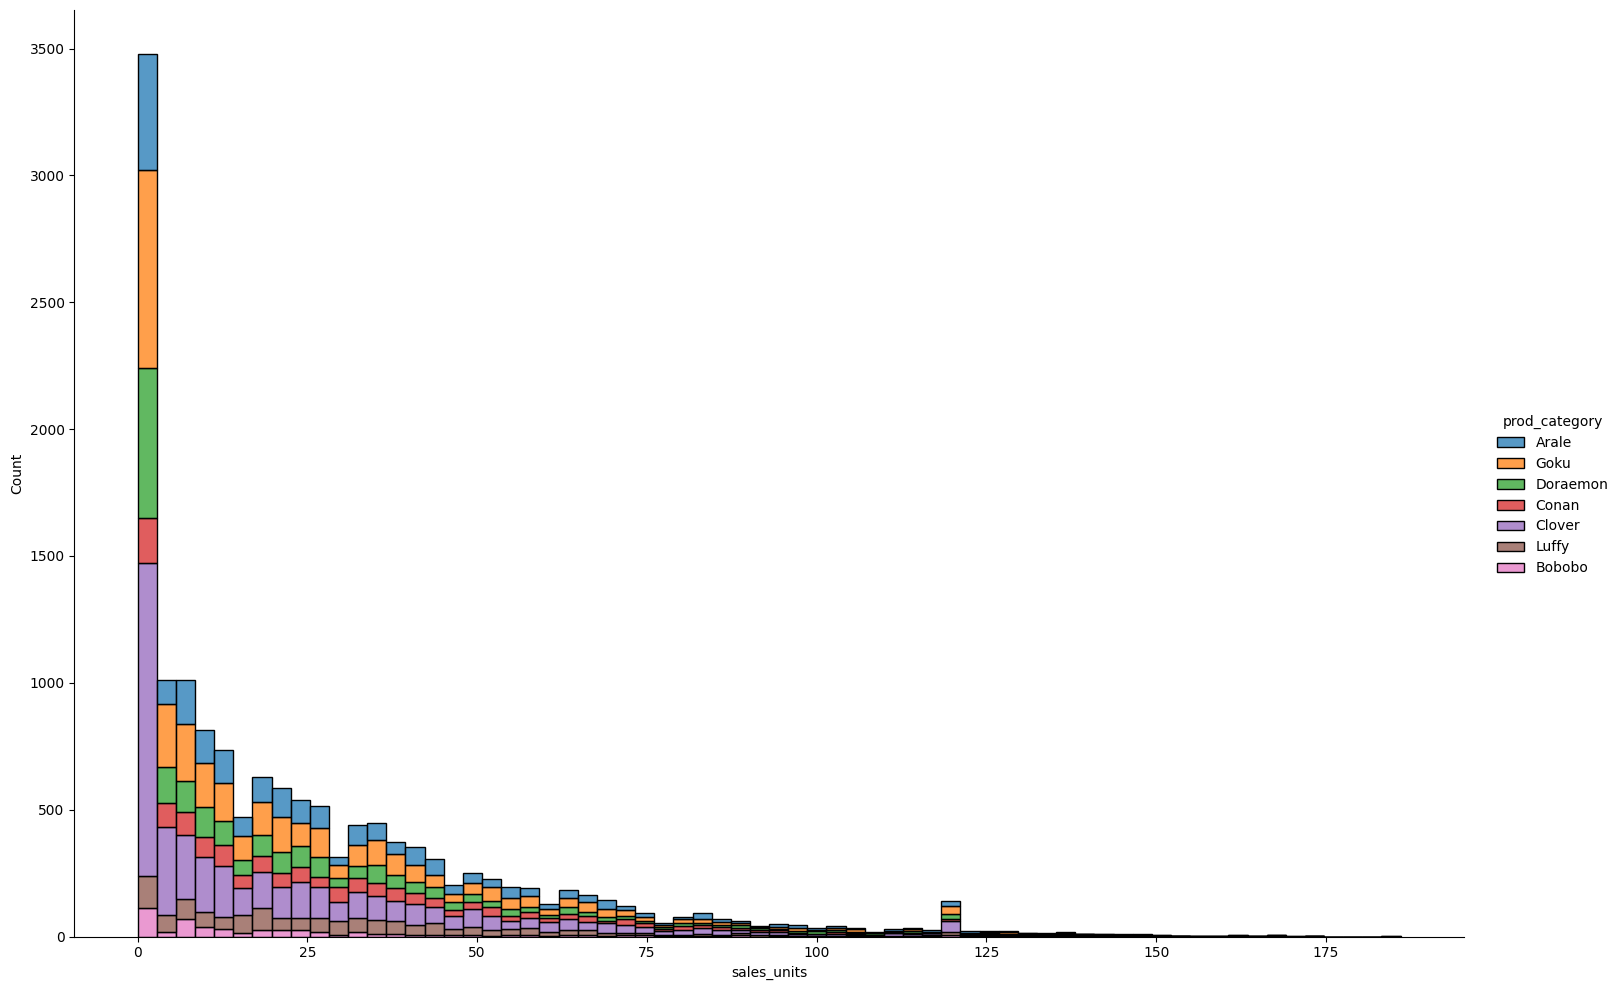

In [16]:
# For each prod_category plot the distribution of sales_units

def plot_sales_dist(df):
    # For each prod_category plot the distribution of sales_units

    sns.displot(df, x='sales_units', hue='prod_category', fill=True, height=10, aspect=1.5, multiple="stack")

plot_sales_dist(train)

In [17]:
# Does each product_number have a unique prod_category?

unique_cat = train.groupby('product_number')['prod_category'].nunique()

unique_cat[unique_cat > 1] # Yes, only one category

Series([], Name: prod_category, dtype: int64)

In [18]:
# Get the number of products in each prod_category

train.groupby('prod_category').agg({'product_number': 'nunique'})

,product_number
prod_category,
Arale,15
Bobobo,4
Clover,28
Conan,8
Doraemon,15
Goku,22
Luffy,8


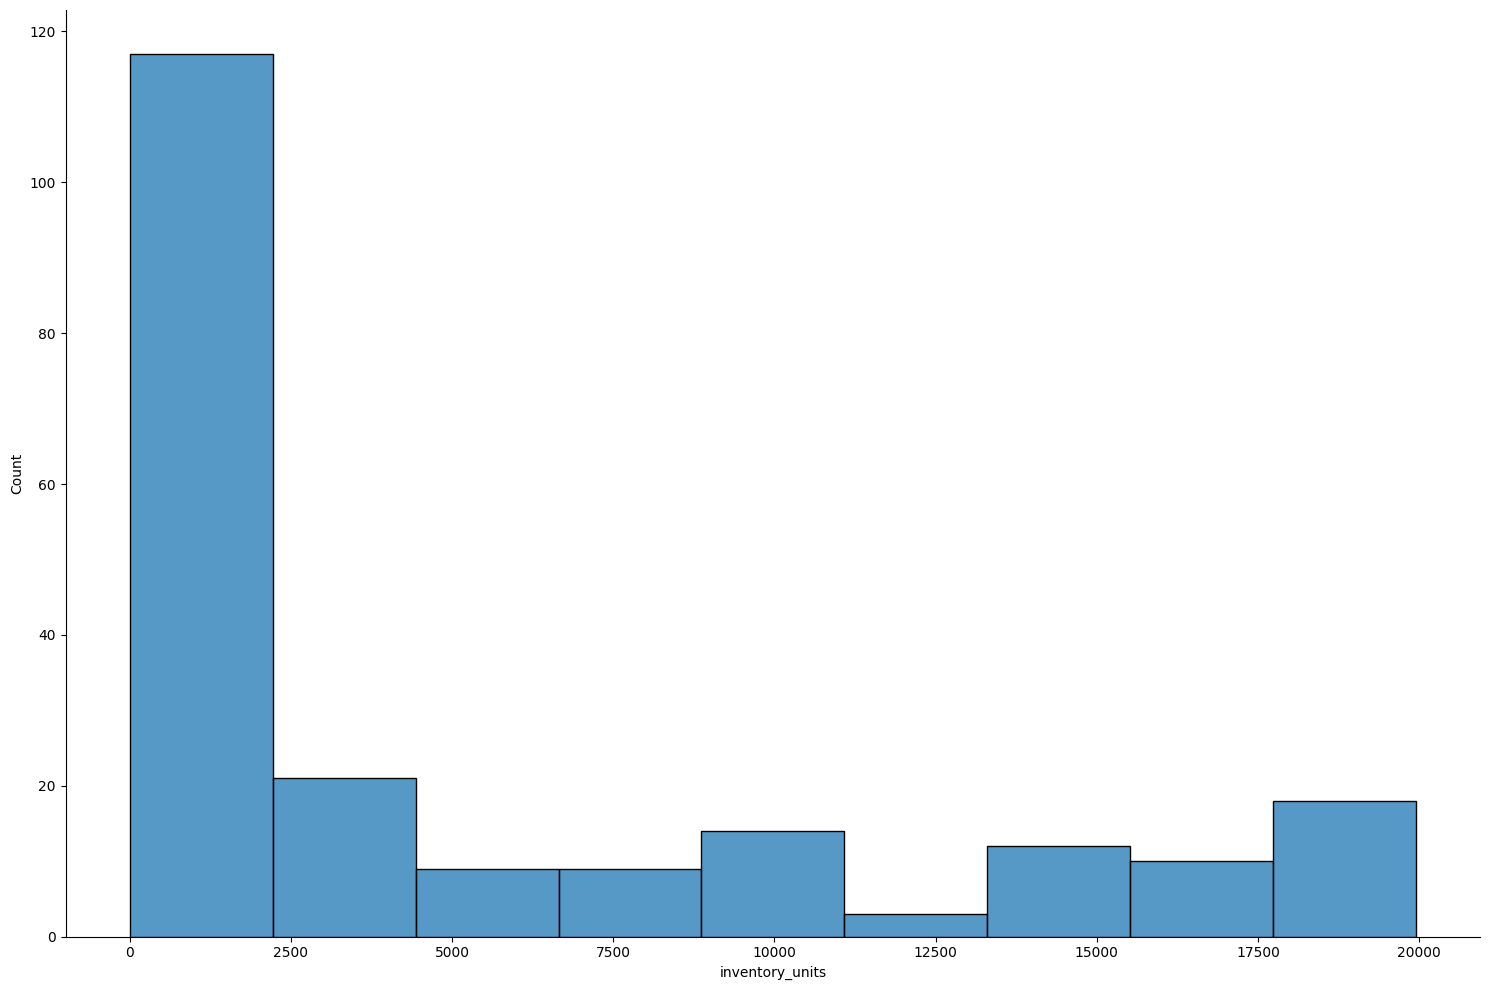

In [19]:
# Plot distribution of inventory_units for any given day

def plot_sales_dist_by_date(df):
    # Plot distribution of inventory_units

    # Group by "date" and calculate total sales of column "inventory_units"

    sales = df.groupby('date').agg({'inventory_units': 'sum'})

    # Plot distribution of inventory_units for any given day

    sns.displot(sales, x='inventory_units', fill=True, height=10, aspect=1.5)

plot_sales_dist_by_date(train)


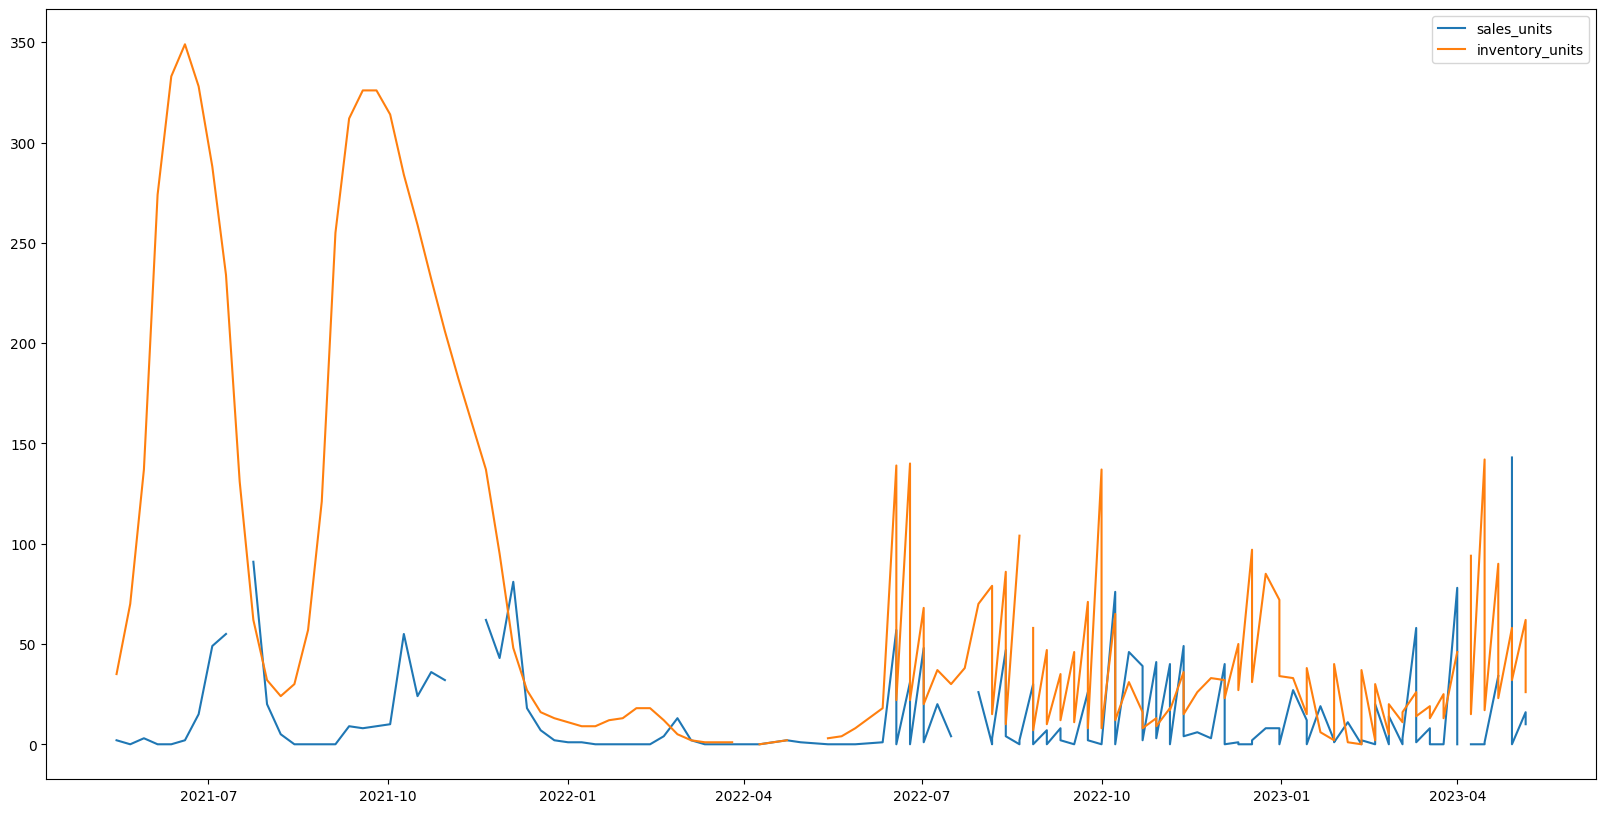

In [20]:

# For each different product_id plot the sales_units and the inventory_units over time

def plot_sales_and_inventory(df, product_id):

    # Filter by "product_id"

    df = df[df['product_number'] == product_id]

    # Plot sales_units and inventory_units over time

    fig, ax = plt.subplots(figsize=(20, 10))

    ax.plot(df['date'], df['sales_units'], label='sales_units')

    ax.plot(df['date'], df['inventory_units'], label='inventory_units')

    ax.legend()

    plt.show()


plot_sales_and_inventory(train, 6909)

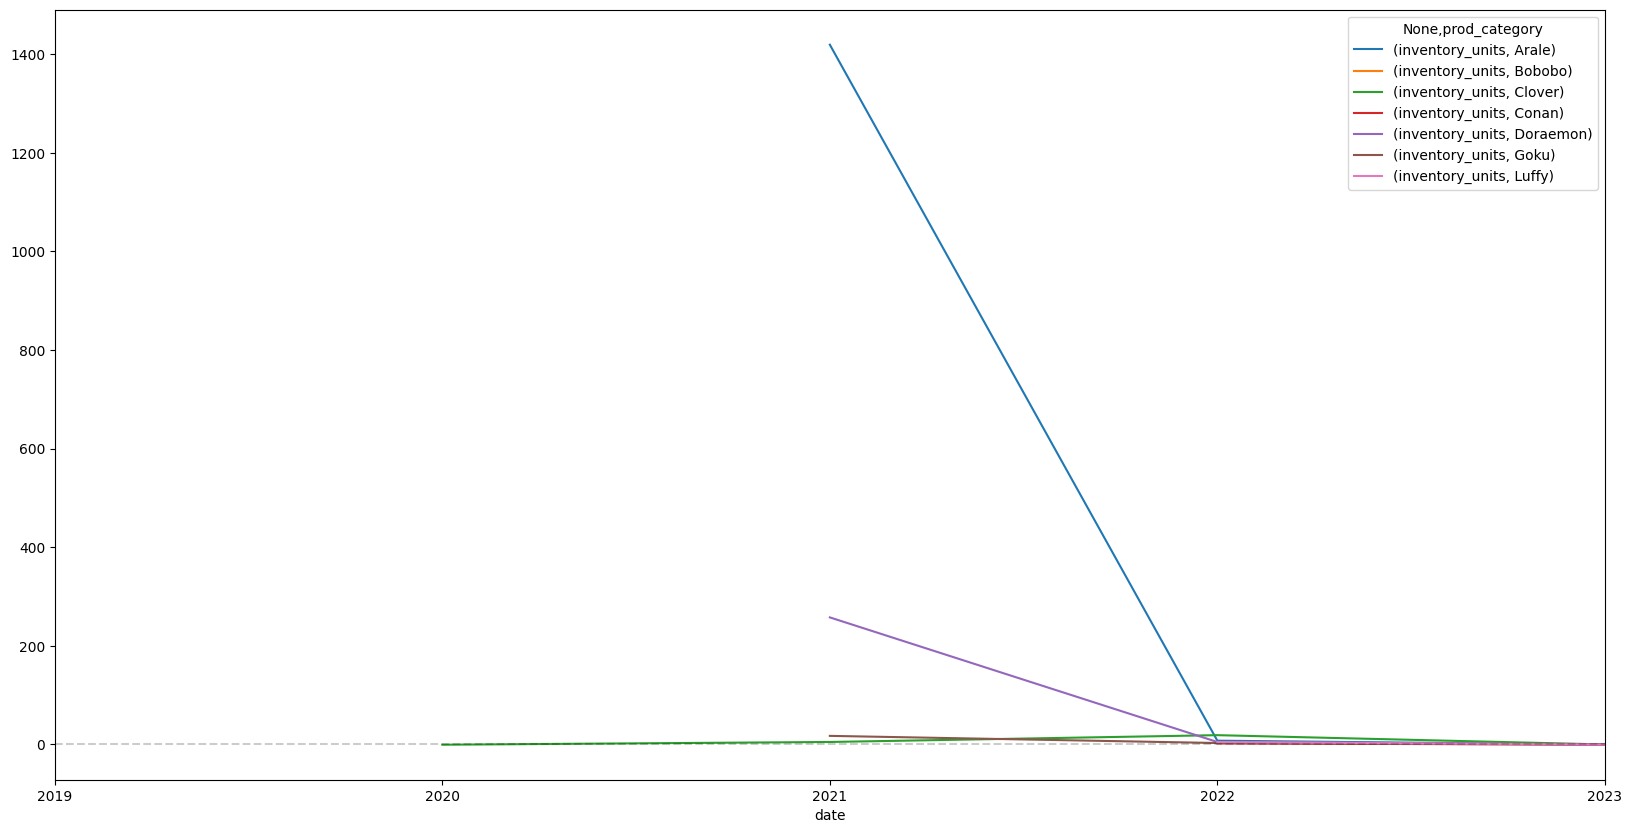

In [21]:
# Plot Y/Y growth of inventory_units for each prod_category

def plot_sales_growth(df):
    # Plot Y/Y growth of inventory_units for each prod_category

    # Group by "date" and "prod_category" and calculate total sales of column "inventory_units" 

    df = df.copy()

    # Map "date" column to year format

    df['date'] = df['date'].map(lambda x: x.strftime('%Y'))

    # Convert "date" column to datetime

    df['date'] = pd.to_datetime(df['date'])

    sales = df.groupby(['date', 'prod_category']).agg({'inventory_units': 'sum'})

    # Plot Y/Y growth of inventory_units for each prod_category

    sales = sales.unstack()

    sales.pct_change().plot(figsize=(20, 10))

    plt.axhline(0, color='k', linestyle='--', alpha=0.2)

    plt.show()

plot_sales_growth(train)

In [22]:
def get_random_colors(num_colors):
    # Get random colors

    import matplotlib, random
    colors = dict(matplotlib.colors.cnames.items())
    hex_colors = tuple(colors.values())
    # print(hex_colors)
    #getting a random color from the dict
    # print(random.choice(hex_colors))

    return hex_colors

# We will now do a Sankey diagram 
# to see the flow of revenue
# There will be 3 columns:
# 1. general revenue (100%)
# 2. revenue from product_category
# 3. revenue from product_id

num_categories = train['prod_category'].nunique()
num_products = train['product_number'].nunique()

source = [0] * num_categories
target = [1 + i for i in range(num_categories)]
label = ['revenue']
color = ['blue']

sales_by_category = train.groupby('prod_category').agg({'sales_units': 'sum'})

sales_by_category = sales_by_category.reset_index().sort_values(by='sales_units', ascending=False)

value = sales_by_category['sales_units'].tolist()

categories_index = {
    category: index + 1
    for index, category in enumerate(sales_by_category['prod_category'])
}
label += sales_by_category['prod_category'].tolist()
source_counter = num_categories + 1
color = get_random_colors(len(label))
color_link = [
    color[i]
    for i in range(1, len(label))
]

for category in train['prod_category'].unique():
    sales_by_product = train[train['prod_category'] == category].groupby('product_number').agg({'sales_units': 'sum'})
    sales_by_product = sales_by_product.reset_index().sort_values(by='sales_units', ascending=False)
    value += sales_by_product['sales_units'].tolist()
    source += [categories_index[category]] * sales_by_product.shape[0]
    target += [source_counter + i for i in range(sales_by_product.shape[0])]
    source_counter += sales_by_product.shape[0]
    label += sales_by_product['product_number'].tolist()
    color_link += [color[categories_index[category]]] * sales_by_product.shape[0]
    # print(category, sales_by_product)
    # break

import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 25,
      thickness = 10,
      line = dict(color = "black", width = 0.5),
      label = label,
      color = color
    ),
    link = dict(
      source = source,
      target = target,
      value = value,
      color = color_link
  ))])

fig.update_layout(title_text="Revenue by product category and actual product", font_size=10)
fig.show()

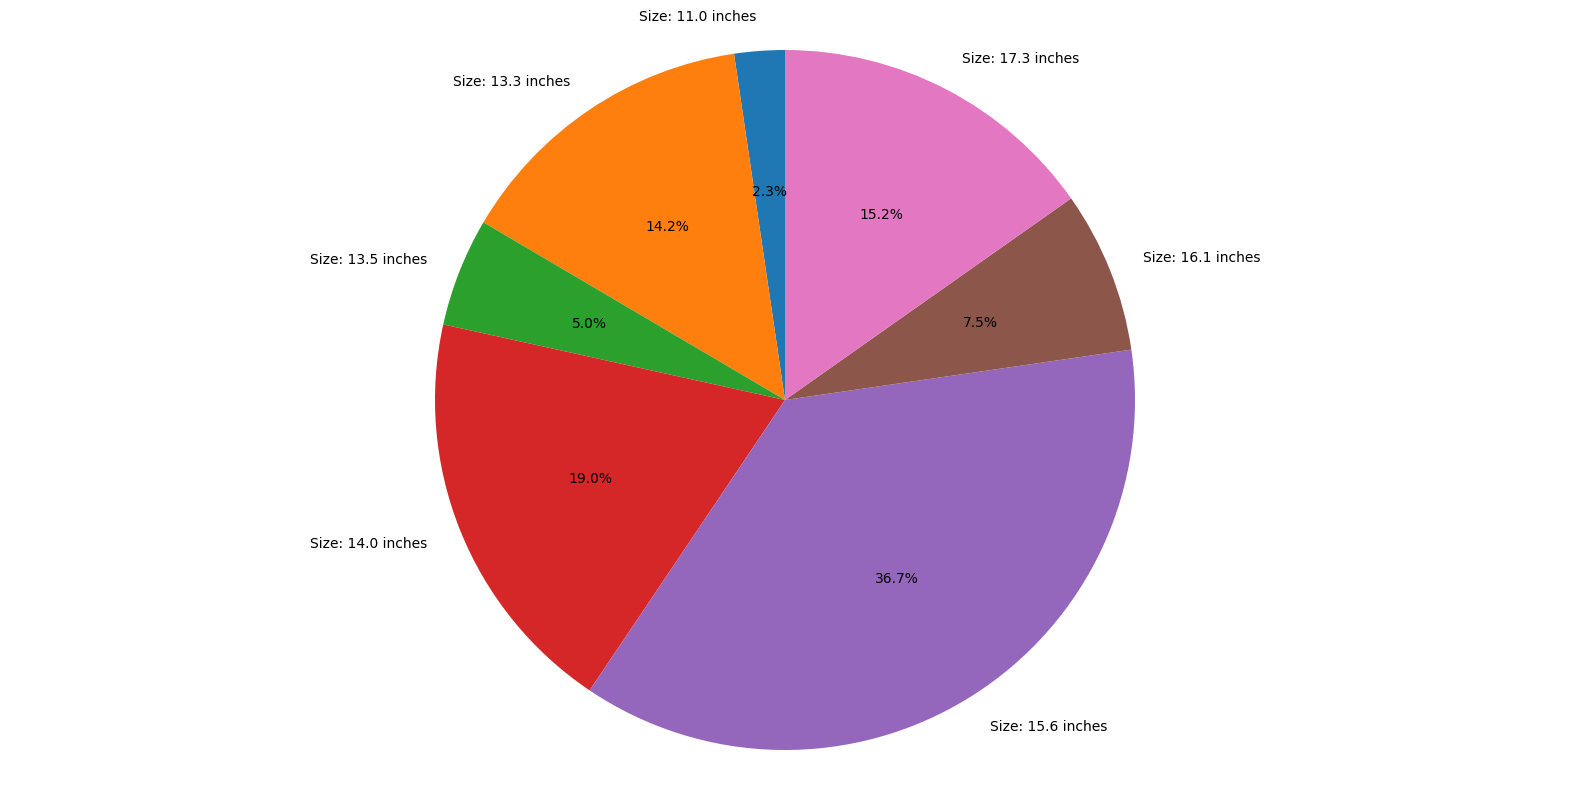

In [23]:
# Pie chart of revenue by display_size

def plot_revenue_group_by(df, group_by):
    # Pie chart of revenue by display_size

    # Group by "display_size" and calculate total sales of column "revenue"

    sales = df.groupby(group_by).agg({'sales_units': 'sum'})

    # Plot pie chart

    fig, ax = plt.subplots(figsize=(20, 10))

    if group_by == 'display_size':
        labels = [
            f'Size: {size} inches' for size in sales.index
        ]
    else:
        labels = sales.index

    ax.pie(sales['sales_units'], labels=labels, autopct='%1.1f%%', startangle=90)

    ax.axis('equal')

    plt.show()

plot_revenue_group_by(train, 'display_size')

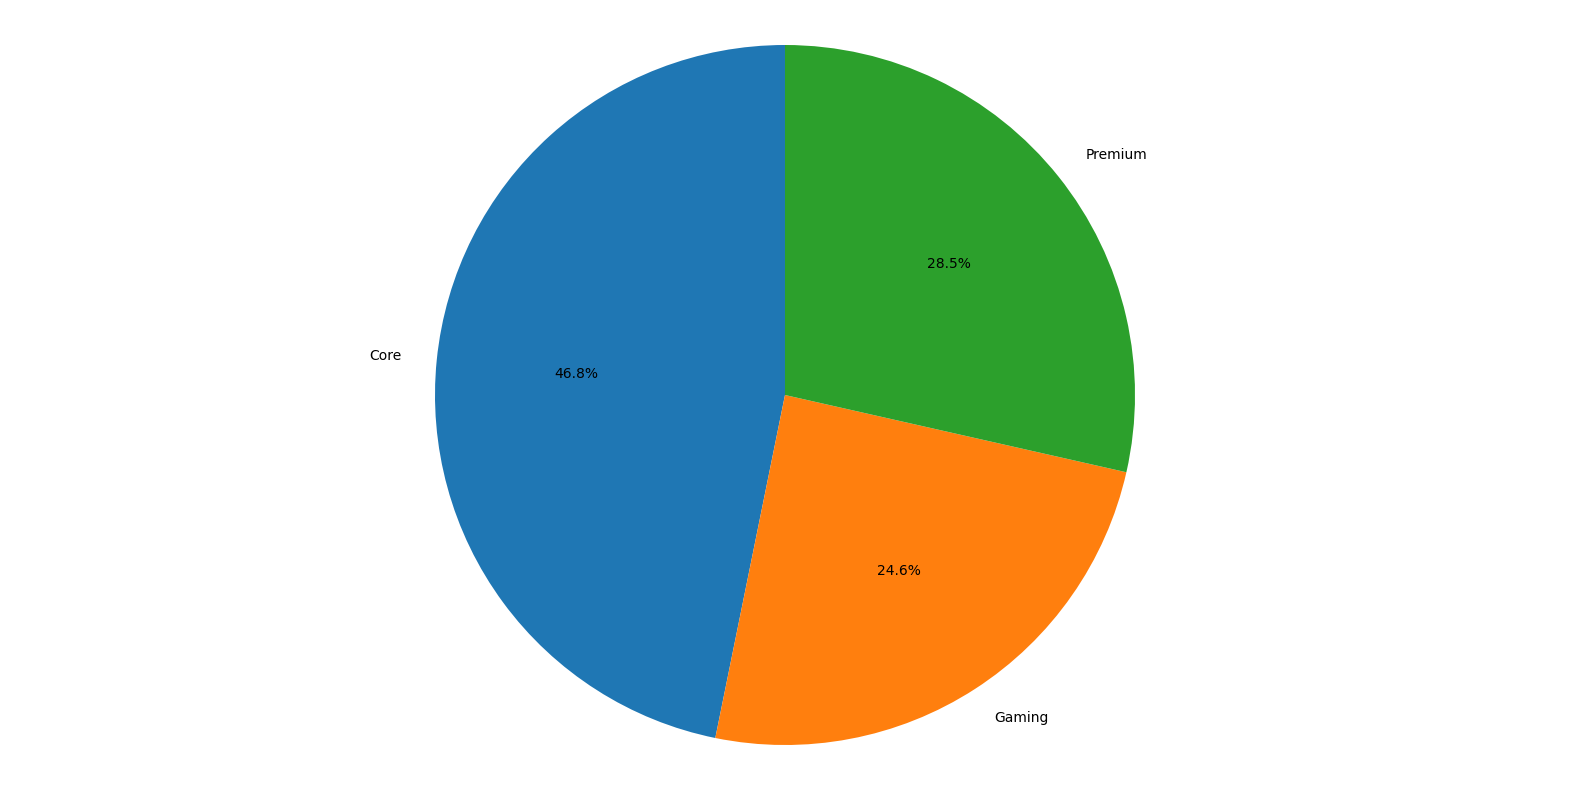

In [24]:
plot_revenue_group_by(train, 'segment')

In [25]:
# Get the number of reporterhq_id

train['reporterhq_id'].nunique()

20

In [26]:
# Get the display_sizes

train['display_size'].unique()

array([13.3, 14. , 15.6, 16.1, 13.5, 17.3, 11. ])

In [27]:
# Get the segments

train['segment'].unique()

array(['Premium', 'Core', 'Gaming'], dtype=object)

In [28]:
# Number of specs for each product

specs_product = train.groupby('product_number').agg({'specs': 'nunique'})

In [29]:
# Get the number of products with more than 1 spec

specs_product[specs_product['specs'] > 1]

# Each product has a single spec

,specs
product_number,


118.93275452870719
Product: 155946


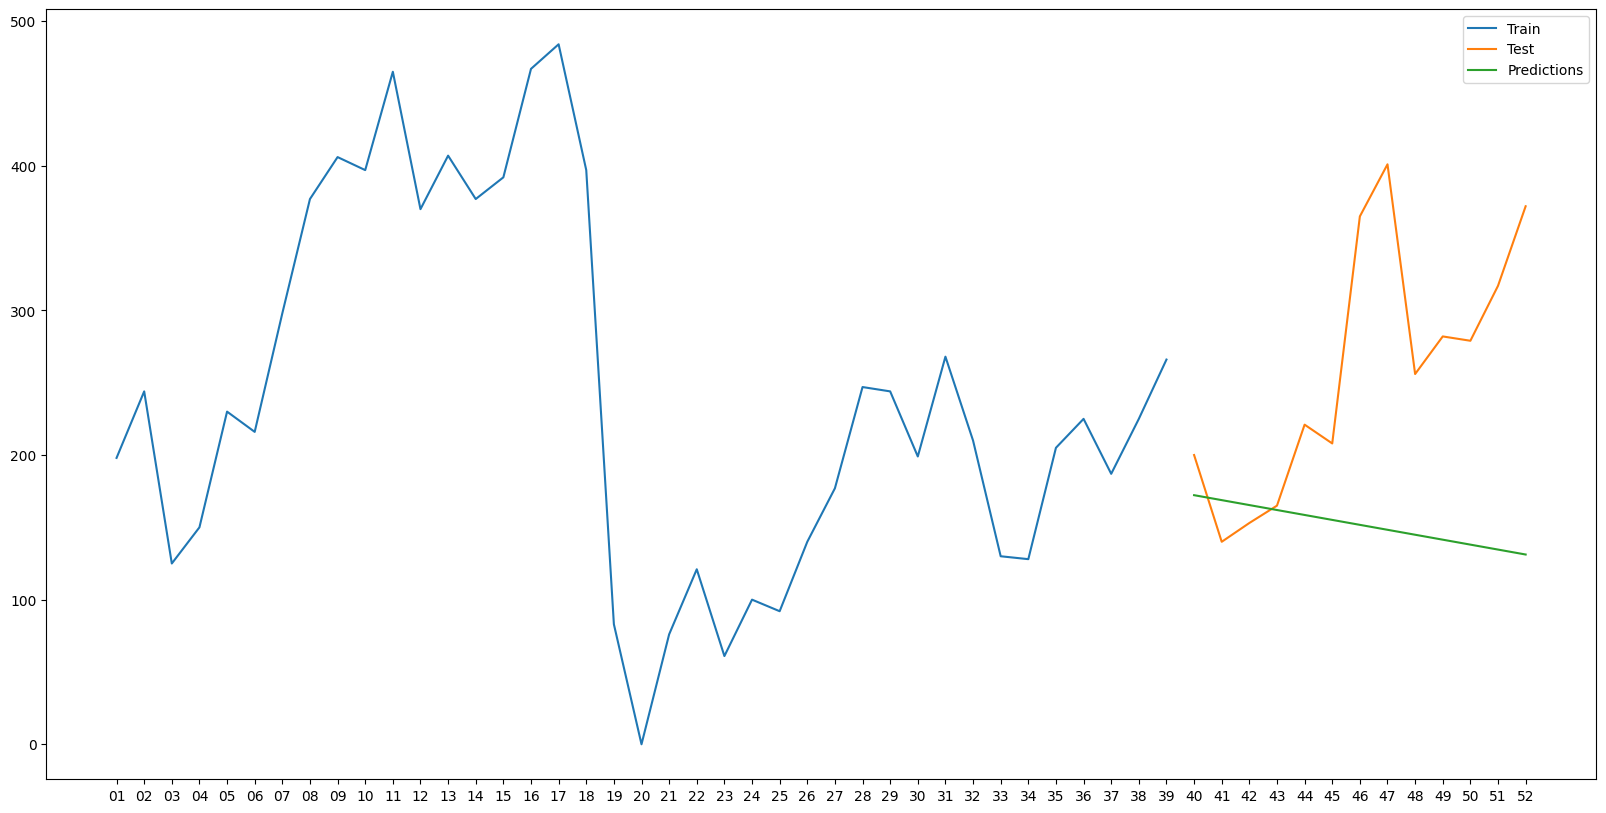

In [64]:
# Now let's make a prediction for the next
PREDICT_WEEKS = 13

# We will use a Linear Regression model

# For this first model we will use only the inventory_units aggregated by week
# and then predict the next weeks by product_number

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error

CONSIDER_FROM = '2022-04-01'

def get_train_test_data(df, product_number, predict_weeks):
    # Get train and test data

    # Filter by "product_number"

    df = df[(df['product_number'] == product_number) & (df['date'] >= CONSIDER_FROM)]
    df = df.copy()

    # Group by "date" and calculate total sales of column "inventory_units"

    df['date'] = df['date'].map(lambda x: x.strftime('%W'))
    sales = df.groupby('date').agg({'inventory_units': 'sum'})

    # Get train and test data

    train = sales[:-predict_weeks]
    test = sales[-predict_weeks:]

    return train, test

def get_X_y(train, test):
    # Get X and y

    X_train = train.index.astype(int).values.reshape(-1, 1)
    y_train = train['inventory_units'].values

    X_test = test.index.astype(int).values.reshape(-1, 1)
    y_test = test['inventory_units'].values

    return X_train, y_train, X_test, y_test

def get_model(X_train, y_train):
    # Get model

    model = LinearRegression()
    model.fit(X_train, y_train)

    return model

def get_predictions(model, X_test):
    # Get predictions

    predictions = model.predict(X_test)

    return predictions

def get_rmse(y_test, predictions):
    # Get RMSE

    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    return rmse

def plot_predictions(train, test, predictions):
    # Plot predictions

    plt.figure(figsize=(20, 10))

    plt.plot(train.index, train['inventory_units'], label='Train')
    plt.plot(test.index, test['inventory_units'], label='Test')
    plt.plot(test.index, predictions, label='Predictions')

    plt.legend()

    plt.show()

def get_predictions_by_product(df, predict_weeks):
    # Get predictions by product

    # Get unique products

    products = df['product_number'].unique()

    # Get predictions by product

    predictions_by_product = {}

    for product in products:
        # Get train and test data

        train, test = get_train_test_data(df, product, predict_weeks)

        # Get X and y

        X_train, y_train, X_test, y_test = get_X_y(train, test)

        # Get model

        model = get_model(X_train, y_train)

        # Get predictions

        predictions = get_predictions(model, X_test)

        # Get RMSE

        rmse = get_rmse(y_test, predictions)

        # Plot predictions

        # plot_predictions(train, test, predictions)

        # Save predictions

        predictions_by_product[product] = {
            'train': train,
            'test': test,
            'predictions': predictions,
            'rmse': rmse
        }

    return predictions_by_product

predictions_by_product = get_predictions_by_product(train, PREDICT_WEEKS)

# Plot predictions

def plot_predictions_by_product(predictions_by_product):
    # Plot predictions by product

    for product, data in predictions_by_product.items():
        # Get train and test data

        train = data['train']
        test = data['test']
        predictions = data['predictions']

        # Plot predictions

        plot_predictions(train, test, predictions)

# plot_predictions_by_product(predictions_by_product)

# Get Average RMSE

def get_average_rmse(predictions_by_product):
    # Get Average RMSE

    rmse = []

    for product, data in predictions_by_product.items():
        rmse.append(data['rmse'])

    return np.mean(rmse)

print(get_average_rmse(predictions_by_product))

# Plot predictions by product of a random product

def plot_predictions_by_product_random(predictions_by_product):
    # Plot predictions by product of a random product

    # Get random product

    product = np.random.choice(list(predictions_by_product.keys()))

    print(f'Product: {product}')

    # Get train and test data

    train = predictions_by_product[product]['train']
    test = predictions_by_product[product]['test']
    predictions = predictions_by_product[product]['predictions']

    # Plot predictions

    plot_predictions(train, test, predictions)

plot_predictions_by_product_random(predictions_by_product)

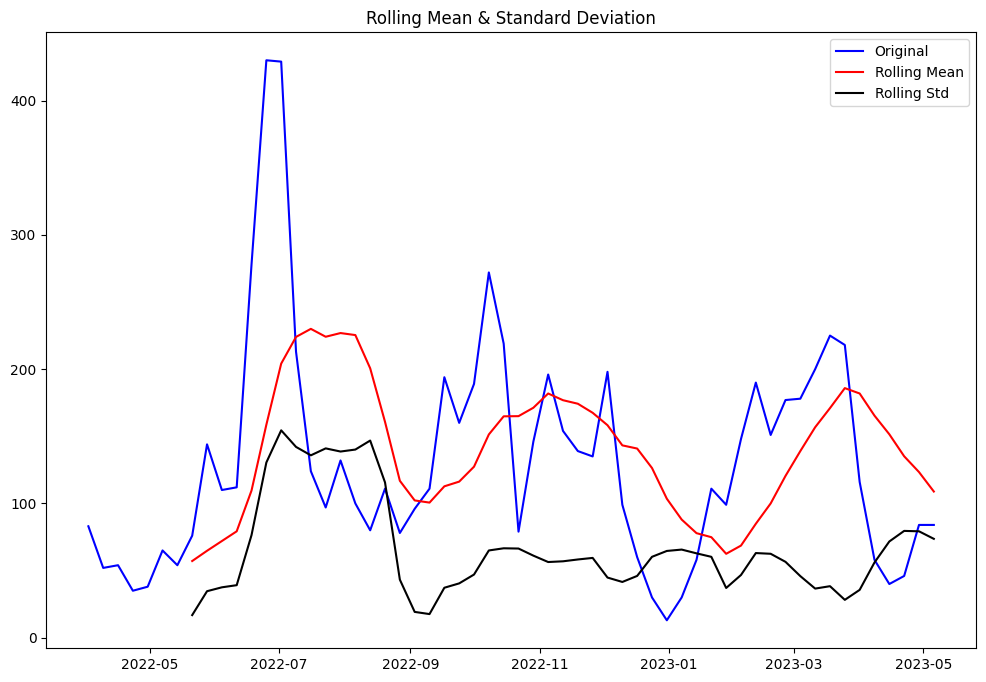

Results of Dickey-Fuller Test:
Test Statistic                 -4.033710
p-value                         0.001244
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


In [65]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window=8):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


station_test = train[(train['product_number'] == 25662) & (train['date'] >= CONSIDER_FROM)]
station_test = station_test.groupby('date').agg({'inventory_units': 'sum'})

test_stationarity(station_test['inventory_units'])
# test_stationarity(train, 6909)

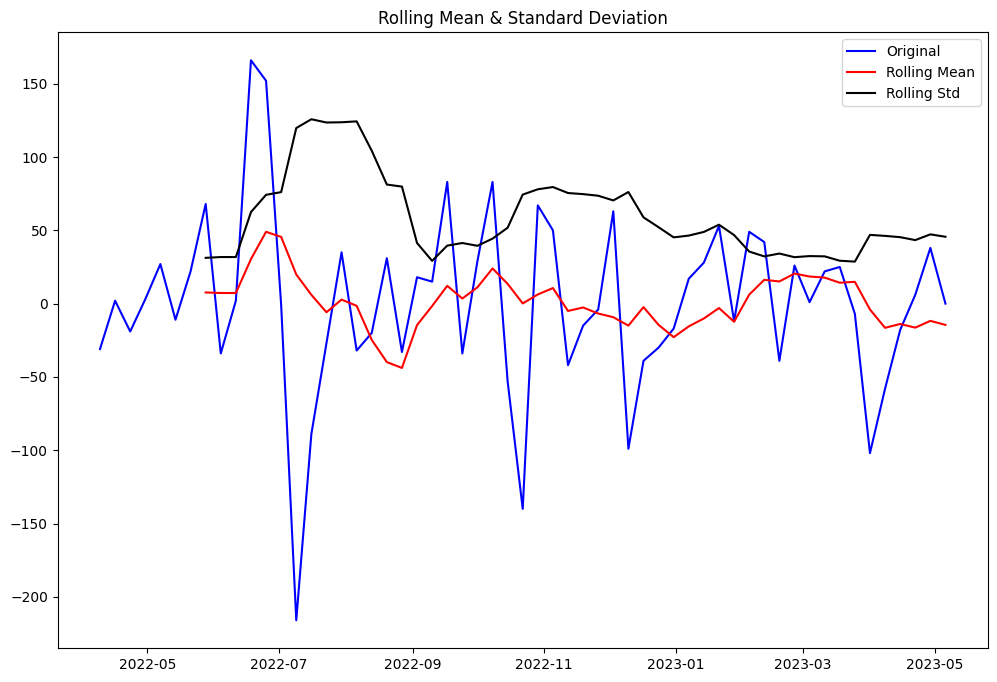

Results of Dickey-Fuller Test:
Test Statistic                 -5.073087
p-value                         0.000016
#Lags Used                     11.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64


In [66]:

train_prepared = train.copy()

# TODO: Fill NaNs

train_prepared = train_prepared[(train_prepared['product_number'] == 25662) & (train_prepared['date'] >= CONSIDER_FROM)]
train_prepared = train_prepared.groupby('date').agg({'inventory_units': 'sum'})['inventory_units']

train_prepared['first_difference'] = train_prepared - train_prepared.shift(1)
test_stationarity(train_prepared['first_difference'].dropna(inplace=False))

timeseries = train_prepared['first_difference']



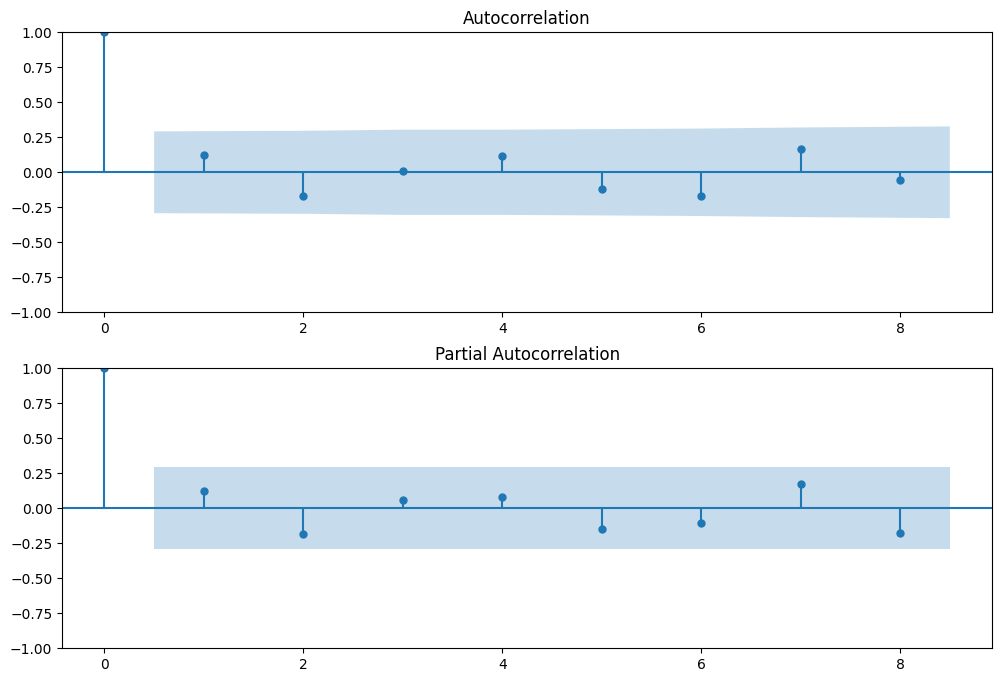

In [67]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

LOOKBACK = 13

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(timeseries.iloc[LOOKBACK:], lags=8, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(timeseries.iloc[LOOKBACK:], lags=8, ax=ax2)

In [68]:
from statsmodels.tsa.arima.model import ARIMA

ORDER = (1, 0, 0)
SEASONAL_ORDER = (1, 1, 1, 2)

mod = ARIMA(station_test['inventory_units'], trend='n', order=ORDER, seasonal_order=SEASONAL_ORDER)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                   inventory_units   No. Observations:                   58
Model:             ARIMA(1, 0, 0)x(1, 1, [1], 2)   Log Likelihood                -308.024
Date:                           Sun, 14 May 2023   AIC                            624.048
Time:                                   03:44:17   BIC                            632.149
Sample:                               04-02-2022   HQIC                           627.189
                                    - 05-06-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8297      0.112      7.435      0.000       0.611       1.048
ar.S.L2       -0.2258      0.173     -1.304

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.



In [69]:
print(station_test)

            inventory_units
date                       
2022-04-02             83.0
2022-04-09             52.0
2022-04-16             54.0
2022-04-23             35.0
2022-04-30             38.0
2022-05-07             65.0
2022-05-14             54.0
2022-05-21             76.0
2022-05-28            144.0
2022-06-04            110.0
2022-06-11            112.0
2022-06-18            278.0
2022-06-25            430.0
2022-07-02            429.0
2022-07-09            213.0
2022-07-16            124.0
2022-07-23             97.0
2022-07-30            132.0
2022-08-06            100.0
2022-08-13             80.0
2022-08-20            111.0
2022-08-27             78.0
2022-09-03             96.0
2022-09-10            111.0
2022-09-17            194.0
2022-09-24            160.0
2022-10-01            189.0
2022-10-08            272.0
2022-10-15            219.0
2022-10-22             79.0
2022-10-29            146.0
2022-11-05            196.0
2022-11-12            154.0
2022-11-19          

<Axes: >

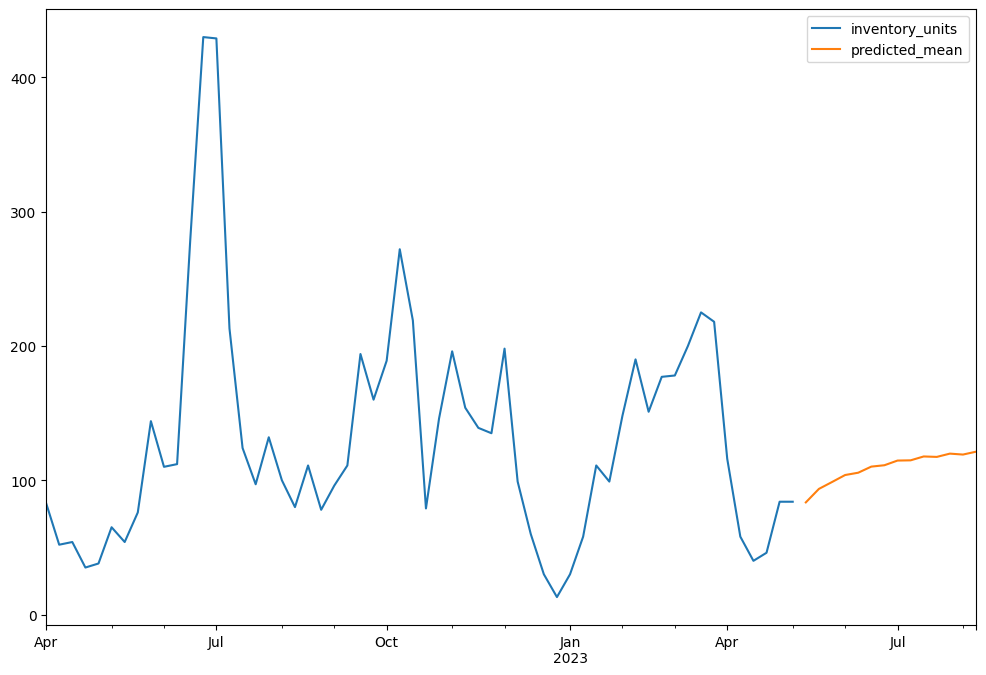

In [70]:
PREDICT_FROM = len(station_test)
PREDICT_TO = PREDICT_FROM + PREDICT_WEEKS

prediction = results.predict(start = PREDICT_FROM, end= PREDICT_TO, dynamic= True)

# Minimum 0 on prediction

prediction[prediction < 0] = 0

# Append predictions to test data as forecast column in new rows
# We cannot directly assign to test['forecast'] because the length of the forecast is different from the length of the test data

pd.concat([station_test, prediction], axis=1).plot(figsize=(12, 8))

In [71]:
# We need to make a model for each product

from datetime import timedelta


def get_model_arima(train):
    # Get model

    mod = ARIMA(train, trend='n', order=ORDER, seasonal_order=SEASONAL_ORDER)
    results = mod.fit()

    return results

def get_prediction(train):
    model = get_model_arima(train)
    PREDICT_FROM = len(station_test)
    PREDICT_TO = PREDICT_FROM + PREDICT_WEEKS
    # Get predictions

    prediction = model.predict(start = PREDICT_FROM, end= PREDICT_TO - 1, dynamic= True)

    # Minimum 0 on prediction

    prediction[prediction < 0] = 0

    return prediction

def get_predictions_by_product(df, product):
    train_prepared = df[df['date'] >= CONSIDER_FROM]
    all_dates = set(train_prepared['date'].unique())
    train_prepared = train_prepared[(train_prepared['product_number'] == product)]
    
    def get_missing_dates():
        dates_product = set(train_prepared['date'].unique())
        missing = all_dates - dates_product
        min_date_product = min(dates_product)
        return [d for d in missing if d > min_date_product]
    missing_dates = get_missing_dates()
    if len(missing_dates) > 0:
        print(f'Product {product} is missing dates {len(missing_dates)}')
        # We will fill the missing dates with the mean of the previous and next date
        dates_product = set(train_prepared['date'].unique())
        sorted_dates = sorted(dates_product)
        for date in missing_dates:
            previous_date = [d for d in sorted_dates if d < date][-1]
            next_date = [d for d in sorted_dates if d > date][0]
            previous_inventory = train_prepared[train_prepared['date'] == previous_date]['inventory_units'].values[0]
            next_inventory = train_prepared[train_prepared['date'] == next_date]['inventory_units'].values[0]
            
            new_row = pd.DataFrame({'date': [date], 'inventory_units': [(previous_inventory + next_inventory) / 2]})
            train_prepared = pd.concat([train_prepared, new_row])

    train_prepared = train_prepared.groupby('date').agg({'inventory_units': 'sum'})['inventory_units']
    
    prediction = get_prediction(train_prepared)

    return prediction

def get_predictions_arima(df):
    predictions_by_product = {}

    for product in df['product_number'].unique():
        prediction = get_predictions_by_product(df, product)

        predictions_by_product[product] = prediction

    return predictions_by_product


predictions_by_product = get_predictions_arima(train)

predictions_by_product


Product 6909 is missing dates 2
Product 7896 is missing dates 2


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be us

Product 8883 is missing dates 1


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be us

Product 11844 is missing dates 2


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning:

Dynamic prediction specified to begin during out-of-sample forecas

Product 14805 is missing dates 2


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be us

Product 46389 is missing dates 4


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be us

Product 58233 is missing dates 1


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/jo

Product 73038 is missing dates 1


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be us

Product 77973 is missing dates 6


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be us

Product 107583 is missing dates 5


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning:

Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so infe

Product 129297 is missing dates 1
Product 130284 is missing dates 2


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning:

Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so infe

Product 138180 is missing dates 2
Product 148050 is missing dates 16


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be us

Product 167790 is missing dates 11
Product 169764 is missing dates 5


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning:

Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so infe

Product 172725 is missing dates 1


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be us

Product 195426 is missing dates 6


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning:

Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning:

Dynamic prediction specified to beg

Product 197400 is missing dates 3
Product 204309 is missing dates 1
Product 205296 is missing dates 4


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning:

Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so infe

Product 231945 is missing dates 3


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be us

Product 237867 is missing dates 2
Product 238854 is missing dates 2
Product 239841 is missing dates 2


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be us

Product 240828 is missing dates 2
Product 242802 is missing dates 2


/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be us

{6909: 2023-05-13    72.222330
 2023-05-20    71.269400
 2023-05-27    60.653845
 2023-06-03    63.176471
 2023-06-10    55.063301
 2023-06-17    59.312410
 2023-06-24    52.394153
 2023-07-01    57.468614
 2023-07-08    51.120531
 2023-07-15    56.588845
 2023-07-22    50.512821
 2023-07-29    56.169063
 2023-08-05    50.222852
 Freq: W-SAT, Name: predicted_mean, dtype: float64,
 7896: 2023-05-13    138.069140
 2023-05-20    123.018683
 2023-05-27    124.539145
 2023-06-03    126.967989
 2023-06-10    124.448701
 2023-06-17    130.334210
 2023-06-24    125.568395
 2023-07-01    131.975675
 2023-07-08    126.236118
 2023-07-15    132.651220
 2023-07-22    126.532561
 2023-07-29    132.907038
 2023-08-05    126.649379
 Freq: W-SAT, Name: predicted_mean, dtype: float64,
 8883: 2023-05-13    161.445128
 2023-05-20    145.553433
 2023-05-27    137.527264
 2023-06-03    128.676923
 2023-06-10    126.785483
 2023-06-17    121.832398
 2023-06-24    122.560358
 2023-07-01    119.221958
 2023-0

In [72]:
# There is a problem with the keys of the pandas series of the dictionary values
# Some of them are integers instead of dates
# If they are an int, we need to convert them to a date
# The base date is 2023-05-06, and each integer is a week after that date


def convert_key_to_date(key, min_key):
    if type(key) is not int:
        return key
    import datetime
    # Convert key to date

    # Get base date

    base_date = datetime.datetime.strptime('2023-05-06', '%Y-%m-%d')

    # Get days to add

    days_to_add = datetime.timedelta(weeks=key - min_key)

    # Add days to base date

    date = base_date + days_to_add

    return date

for product in predictions_by_product:
    min_key = min(predictions_by_product[product].keys())
    predictions_by_product[product].rename(lambda x: convert_key_to_date(x, min_key), inplace=True)

In [73]:
# Now we have a way to predict the next PREDICT_WEEKS weeks for each product
# We need to get the predictions for the test data (which need to be removed from the train data)
# We want to get the RMSE for each product and the average RMSE

def test_arima(train, product_id):
    train, test = get_train_test_data(train, product_id, PREDICT_WEEKS)

    prediction = predictions_by_product[product_id]
    # print(len(test), len(prediction), prediction)

    rmse = np.sqrt(mean_squared_error(test, prediction))
    rmsle = np.sqrt(mean_squared_log_error(test, prediction))

    return rmse, rmsle

def test_arima_all(df):
    rmses = []
    rmsles = []

    for product in df['product_number'].unique():
        rmse, rmlse = test_arima(df, product)
        rmses.append(rmse)
        rmsles.append(rmlse)

    return rmses, rmsles

rmses, rmsles = test_arima_all(train)

# Get average RMSE

print(f'Average RMSE: {np.mean(rmses)}')
print(f'Average RMSLE: {np.mean(rmsles)}')

Average RMSE: 90.7197062278757
Average RMSLE: 0.720786291310031


In [63]:
# Now we will define the functions to save the predictions to a file

def save_predictions(predictions_by_product, to_predict_df, train):
    # the "to_predict_df" has as the column id:
    # "{year}{week}-{product_id}"
    # We need to get the year, week and product_id from this column
    # and then get the prediction from the predictions_by_product dictionary

    # Create a new column with the prediction
    to_predict_df = to_predict_df.copy()
    to_predict_df['inventory_units'] = 0

    for index, row in to_predict_df.iterrows():
        BASE_WEEK = 19
        year = row['id'][:4]
        week = row['id'][4:6]
        product_id = row['id'][7:]
        assert year == '2023'

        prediction = predictions_by_product[int(product_id)].values[int(week) - BASE_WEEK]

        to_predict_df.at[index, 'inventory_units'] = prediction

    # Save to csv
    to_predict_df[['id', 'inventory_units']].to_csv('submission.csv', index=False)

    # For each product we want to save an image with the prediction and the real data
    for product_id in train['product_number'].unique():
        prediction = predictions_by_product[product_id]
        # Aggregate train data
        train_product = train[train['product_number'] == product_id]
        train_product = train_product.groupby('date').agg({'inventory_units': 'sum'})['inventory_units']

        plt.figure(figsize=(12, 8))
        plt.plot(train_product, label='Train')
        plt.plot(prediction, label='Prediction')
        plt.legend(loc='best')
        plt.title(f'Product {product_id}')
        plt.savefig(f'prediction/{product_id}.png')
        plt.close()


save_predictions(predictions_by_product, test, train)